In [1]:
#!/usr/bin/python
import numpy as np
import scipy.sparse
import pickle
import xgboost as xgb
import csv
from collections import defaultdict
import redis
import json
import time
import sklearn.utils
### simple example
# load file from text file, also binary buffer generated by xgboost
# dtrain = xgb.DMatrix('./demo/rank_aida/mq2008.train')

# dtest = xgb.DMatrix('./demo/rank_aida/mq2008.test')

/import/sigmod01/1/scratch/z5109197/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
conn = redis.Redis(password='unswkg', host='43.240.97.73', port=8379, decode_responses=True)

def get_feature_results(exp_id, d_t, data_source='aida_conll'):
    fea_res = conn.lrange('result:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t), 0, -1)
    fea_vecs = [json.loads(res) for res in fea_res]
    return fea_vecs

In [3]:
def get_dataset_info(exp_id, d_t, data_source='aida_conll', can_size=50):
    valid_mens_size = conn.scard('valid_qry_ids:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    no_g_can_info_size = conn.scard('no_g_candidate_info:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    missed_g_candidate_size = conn.scard('missed_g_candidate:::::' + str(exp_id) + ':::::' + data_source + 
                                         ':::::' + str(d_t) + ':::::' + str(can_size))
    no_candidate_size = conn.scard('no_candidate:::::' + str(exp_id) + ':::::' + data_source + ':::::' + str(d_t))
    return valid_mens_size, no_candidate_size, no_g_can_info_size, missed_g_candidate_size

In [13]:
def fetch_all_features(exp_id, data_type, data_source='aida_conll'):
    res_feas = get_feature_results(exp_id, data_type, data_source)
    res_feas_ids = [[res[0].strip('(').split(', ')[0]] + res[4:-1] + [res[-1]] for res in res_feas]
    res_feas_ids = np.array(res_feas_ids, dtype=np.float64)
    return res_feas_ids

In [5]:
def fetch_all_features_delete_max_prior(exp_id, data_type, data_source='aida_conll'):
    res_feas = get_feature_results(exp_id, data_type, data_source)
    res_feas_ids = [[res[0].strip('(').split(', ')[0]] + res[1:2] + [res[2] if res[2]!=0 else res[1]] + res[3:] for res in res_feas]
    res_feas_ids = np.array(res_feas_ids, dtype=np.float64)
    return res_feas_ids

In [5]:
def trans_data(data):
    d_np = data[:, 1:-1]
    print(d_np)
    d_labels = data[:, -1]
    print(d_labels)
    idxs = np.where(d_labels == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_labels)) - idxs
    print(d_groups)
    xgb_data = xgb.DMatrix(data=d_np, label=d_labels)
    xgb_data.set_group(d_groups)
    return xgb_data

In [6]:
def combine_features(original_feas, new_features):
    men_id_feas_dict = defaultdict(list)
    print("Building idx for new features...")
    for fea in new_features:
        men_id_feas_dict[fea[0]].append(fea)
    comb_feas = None
    pre_men_id = 0
    print("Combine original and new features...")
    for fea_idx, fea in enumerate(original_feas):
        if pre_men_id == fea[0]:
            continue
        else:
            pre_men_id = fea[0]
            fea_size = len(men_id_feas_dict[fea[0]])
            res = np.append(original_feas[fea_idx: fea_idx + fea_size, :-1], np.array(men_id_feas_dict[fea[0]])[:, 1:], axis=1)
            comb_feas = np.concatenate((comb_feas, res), axis=0) if comb_feas is not None else res
    return comb_feas

In [7]:
def evalerror(preds, dt, d_tal_size):
    d_l = dt.get_label()
    idxs = np.where(d_l == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_l)) - idxs
    matched_ids = []
    q_id = 0
    for x in d_groups:
        pre_res = preds[q_id: x + q_id]
        if(preds[q_id] == max(pre_res)):
            if len([x for x in pre_res if x == preds[q_id]]) == 1:
                matched_ids.append(q_id)
        q_id += x
    precision = float(len(matched_ids)) / len(d_groups)
    recall = float(len(matched_ids)) / d_tal_size
    f1 = 2 * precision * recall / (precision + recall)
    return len(matched_ids), precision, recall, f1

In [8]:
from collections import defaultdict
def evalerror_detail_log(preds, dt, d_tal_size):
    d_l = dt.get_label()
    idxs = np.where(d_l == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_l)) - idxs
    correct_results = {}
    wrong_results = {}
    duplicates_results = {}
    group_info = {}
    matched_ids = []
    q_id = 0
    for x in d_groups:
        pre_res = preds[q_id: x + q_id]
        if(preds[q_id] == max(pre_res)):
            correct_results[q_id] = pre_res
            if len([x for x in pre_res if x == preds[q_id]]) == 1:
                matched_ids.append(q_id)
            else:
                duplicates_results[q_id] = pre_res
        else:
            wrong_results[q_id] = pre_res
        q_id += x
    precision = float(len(matched_ids)) / len(d_groups)
    recall = float(len(matched_ids)) / d_tal_size
    f1 = 2 * precision * recall / (precision + recall)
    return len(matched_ids), precision, recall, f1, correct_results, wrong_results, duplicates_results

In [9]:
from collections import defaultdict
from ast import literal_eval
def get_groups_results(preds, dt, d_tal_size, res_features):
    d_l = dt.get_label()
    idxs = np.where(d_l == 1)[0]
    d_groups = np.append(np.delete(idxs, 0), len(d_l)) - idxs
#     correct_results = {}
#     wrong_results = {}
#     duplicates_results = {}
#     group_info = {}
#     matched_ids = []
    correct_res_groups = []
    wrong_res_groups = []
    dup_res_groups = []
    q_id = 0
    for x in d_groups:
        pre_res = preds[q_id: x + q_id]
        pre_res_feas = res_features[q_id: x + q_id]
        pred_q_id, pred_ent = literal_eval(res_features[q_id+np.argmax(pre_res)][0])
        
        if(preds[q_id] == max(pre_res)):
            correct_res_groups.append([pred_q_id, pred_ent])
        else:
            wrong_res_groups.append([pred_q_id, pred_ent])
        q_id += x
#     precision = float(len(matched_ids)) / len(d_groups)
#     recall = float(len(matched_ids)) / d_tal_size
#     f1 = 2 * precision * recall / (precision + recall)
    return correct_res_groups, wrong_res_groups

In [48]:
valid_mens_size, no_candidate_size, no_g_can_info_size, missed_g_candidate_size = get_dataset_info('basic_feature_phrases_tf_idf_entropy_reduced_fea', 'test', 'wiki_uiuc')

In [ ]:
d_train_ori = fetch_all_features('basic_feature_phrases_tf_idf_entropy_conll_new', 'train', 'aida_conll')
d_test_a_ori = fetch_all_features('basic_feature_phrases_tf_idf_entropy_conll_new', 'testa', 'aida_conll')

In [70]:
n_estimators = range(100, 5000, 400)
max_depth = [4, 6, 8, 10, 12]

In [20]:
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        bst = xgb.train(param, dtrain, num_round)
        preds = bst.predict(dtrain)
        a = evalerror(preds, dtrain, 18541)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[0], a[1]))
        preds = bst.predict(dtest)
        a = evalerror(preds, dtest, 4485)
        print("n_estimators: {}, max_depth: {}, acc_testing: {}, corr_num: {}".format(num_round, dep, a[0], a[1]))
        print("---------------------------------")

n_estimators: 100, max_depth: 4, acc_training: 0.7711558168383582, corr_num: 14298
n_estimators: 100, max_depth: 4, acc_testing: 0.7163879598662207, corr_num: 3213
---------------------------------
n_estimators: 100, max_depth: 6, acc_training: 0.8203441022598565, corr_num: 15210
n_estimators: 100, max_depth: 6, acc_testing: 0.7868450390189521, corr_num: 3529
---------------------------------
n_estimators: 100, max_depth: 8, acc_training: 0.879564209050213, corr_num: 16308
n_estimators: 100, max_depth: 8, acc_testing: 0.8133779264214047, corr_num: 3648
---------------------------------
n_estimators: 100, max_depth: 10, acc_training: 0.9209859230893696, corr_num: 17076
n_estimators: 100, max_depth: 10, acc_testing: 0.8251950947603122, corr_num: 3701
---------------------------------
n_estimators: 500, max_depth: 4, acc_training: 0.8502238282724772, corr_num: 15764
n_estimators: 500, max_depth: 4, acc_testing: 0.8013377926421404, corr_num: 3594
---------------------------------
n_estimat

In [10]:
d_train_ori = fetch_all_features('basic_context_emnlp17_spacy_sm_50_new', 'train', 'aida_conll')
d_test_a_ori = fetch_all_features('basic_context_emnlp17_spacy_sm_50_new', 'testa', 'aida_conll')
d_test_b_ori = fetch_all_features('basic_context_emnlp17_spacy_sm_50_new', 'testb', 'aida_conll')

In [12]:
d_train_ori[0]

array([  3.85457000e+05,   6.42493639e-02,   7.70356234e-01,
         6.54988716e-06,   2.70000000e+01,   5.73519596e+00,
         8.17157366e+00,   0.00000000e+00,   1.01902872e+01,
         1.41065206e+01,   1.34242268e+00,   3.61991676e-02,
         4.88386909e-02,   1.23800656e-02,   1.75188050e-02,
         2.94215413e-02,   1.00000000e+00])

In [23]:
# d_test_a_ori_sup = fetch_all_features('basic_feature_phrases_tf_idf_entropy_conll_new_sup', 'testa', 'aida_conll')
d_test_b_ori_sup = fetch_all_features('basic_context_emnlp17_spacy_sm_50_new_sup', 'testb', 'aida_conll')

In [14]:
d_train_new_coref = fetch_all_features('basic_features_coref_emnlp17_spacy_sm_50', 'train', 'aida_conll')
d_test_a_new_coref = fetch_all_features('basic_features_coref_emnlp17_spacy_sm_50', 'testa', 'aida_conll')
d_test_b_new_coref = fetch_all_features('basic_features_coref_emnlp17_spacy_sm_50', 'testb', 'aida_conll')

In [24]:
# d_test_a_new_coref_sup = fetch_all_features('basic_feature_coref_smooth_sup', 'testa', 'aida_conll')
d_test_b_new_coref_sup = fetch_all_features('basic_features_coref_emnlp17_spacy_sm_50_sup', 'testb', 'aida_conll')

In [13]:
d_train_new_coref = fetch_all_features_delete_max_prior('basic_feature_coref_smooth', 'train', 'aida_conll')
d_test_a_new_coref = fetch_all_features_delete_max_prior('basic_feature_coref_smooth', 'testa', 'aida_conll')
d_test_b_new_coref = fetch_all_features_delete_max_prior('basic_feature_coref_smooth', 'testb', 'aida_conll')

In [15]:
d_train_new_coref[0]

array([  3.82031000e+05,   3.30320972e-02,   3.30320972e-02,
         3.30320972e-02,   5.00000000e-01,   9.00000000e-01,
         1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.00000000e+00])

In [16]:
d_train_comb = combine_features(d_train_ori, d_train_new_coref)
d_test_a_comb = combine_features(d_test_a_ori, d_test_a_new_coref)
d_test_b_comb = combine_features(d_test_b_ori, d_test_b_new_coref)

Building idx for new features...
Combine original and new features...
Building idx for new features...
Combine original and new features...
Building idx for new features...
Combine original and new features...


In [25]:
# d_test_a_comb_sup = combine_features(d_test_a_ori_sup, d_test_a_new_coref_sup)
d_test_b_comb_sup = combine_features(d_test_b_ori_sup, d_test_b_new_coref_sup)

Building idx for new features...
Combine original and new features...


In [17]:
dtrain_xgboost = trans_data(d_train_comb)
dtest_a_xgboost = trans_data(d_test_a_comb)
dtest_b_xgboost = trans_data(d_test_b_comb)

[[  6.42493639e-02   7.70356234e-01   6.54988716e-06 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  7.70356234e-01   7.70356234e-01   1.39400559e-05 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  4.45292621e-03   7.70356234e-01   8.61827258e-08 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  9.15667063e-05   9.66669719e-01   1.29274089e-07 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.66669719e-01   9.62373771e-07 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.66669719e-01   5.74551505e-08 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]]
[ 1.  0.  0. ...,  0.  0.  0.]
[22  1 50 ...,  9 25 38]
[[  9.90361446e-01   9.90361446e-01   2.90794881e-05 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   9.90361446e-01   2.65730071e-07 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.83783784e-01   7.83783784e-01   4.

In [26]:
# dtest_a_xgboost_sup = trans_data(d_test_a_comb_sup)
dtest_b_xgboost_sup = trans_data(d_test_b_comb_sup)

[[  6.71836929e-01   6.71836929e-01   3.44000000e+02 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.85356867e-01   6.71836929e-01   3.44000000e+02 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.41873180e-02   6.71836929e-01   3.44000000e+02 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   3.09178744e-01   1.10000000e+01 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.09178744e-01   1.10000000e+01 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.09178744e-01   1.10000000e+01 ...,   0.00000000e+00
    1.00000000e+00   0.00000000e+00]]
[ 1.  0.  0. ...,  0.  0.  0.]
[50 50 50 50 50 50  4 50 50 50 50 50 50 50 50 14 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 14 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
  5 50  7 50 50 50 50 50 49 49 50 49 50 50 50 50 50 50 50 50 50 50]


In [22]:
data_train = './dtrain_xgboost.dat'
data_testa = './dtesta_xgboost.dat'
data_testb = './dtestb_xgboost.dat'
data_names = [data_train, data_testa, data_testb]
datas = [dtrain_xgboost, dtest_a_xgboost, dtest_b_xgboost]
for data_name, data in zip(data_names, datas):
    data.save_binary(data_name, silent=True)


In [ ]:
save_binary(fname, silent=True)

In [18]:
n_estimators = [49000]
max_depth = [6]

In [19]:
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        bst = xgb.train(param, dtrain_xgboost, num_round)
        preds = bst.predict(dtrain_xgboost)
        a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_a_xgboost)
        a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)
        
        print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_b_xgboost)
        a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
        print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        print("---------------------------------")

KeyboardInterrupt: 

In [ ]:
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01, 'nthread': 1, 'tree_method': 'gpu_exact'}
        bst = xgb.train(param, dtrain_xgboost, num_round)
        preds = bst.predict(dtrain_xgboost)
        a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
        print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_a_xgboost)
        a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)
        
        print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        preds = bst.predict(dtest_b_xgboost)
        a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
        print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
        print("---------------------------------")

In [21]:
num_round = 5300
dep = 6
param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
bst = xgb.train(param, dtrain_xgboost, num_round)
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_training: 0.973194541826223, corr_num: 18044
n_estimators: 4900, max_depth: 6, acc_validation: 0.8925067835524942, corr_num: 4276
n_estimators: 4900, max_depth: 6, acc_test: 0.8648829431438128, corr_num: 3879


In [141]:
num_round = 4900
dep = 6
param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
bst = xgb.train(param, dtrain_xgboost, num_round)
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_training: 0.9778868453697211, corr_num: 18131
n_estimators: 4900, max_depth: 6, acc_validation: 0.9018993946983929, corr_num: 4321
n_estimators: 4900, max_depth: 6, acc_test: 0.8909698996655518, corr_num: 3996


In [181]:
num_round = 4900
dep = 6
param = {'max_depth':dep, 'eta':0.01, 'silent':1, 'objective':'rank:pairwise', 'min_child_weight':0.01}
bst = xgb.train(param, dtrain_xgboost, num_round)
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_training: 0.9778868453697211, corr_num: 18131
n_estimators: 4900, max_depth: 6, acc_validation: 0.9010644959298685, corr_num: 4317
n_estimators: 4900, max_depth: 6, acc_test: 0.8916387959866221, corr_num: 3999


### Save Model

In [22]:
model_name = './4900_6_coref_new_emnlp17_for_review.mdl'
with open(model_name, 'wb') as f:
    pickle.dump(bst, f)
model = pickle.load(open(model_name, 'rb'))

### Load Model

In [25]:
model_name = './4900_6_coref_new_emnlp17_for_review.mdl'
# with open(model_name, 'wb') as f:
#     pickle.dump(bst, f)
model = pickle.load(open(model_name, 'rb'))
bst = model

In [15]:
bst = model
num_round = 4900
dep = 6
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

NameError: name 'num_round' is not defined

In [34]:
preds = bst.predict(dtrain_xgboost)
a = evalerror_detail_log(preds, dtrain_xgboost, 18541)
print("n_estimators: {}, max_depth: {}, acc_training: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 49000, max_depth: 6, acc_training: 0.9723315894504072, corr_num: 18028


In [51]:
preds = bst.predict(dtest_a_xgboost)
a = evalerror_detail_log(preds, dtest_a_xgboost, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 49000, max_depth: 6, acc_validation: 0.894385305781674, corr_num: 4285


In [37]:
preds = bst.predict(dtest_b_xgboost)
a = evalerror_detail_log(preds, dtest_b_xgboost, 4485)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_test: 0.8648829431438128, corr_num: 3879


In [42]:
preds = model.predict(dtest_b_xgboost_sup)
a = evalerror_detail_log(preds, dtest_b_xgboost_sup, 72)
print("n_estimators: {}, max_depth: {}, acc_test: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_test: 0.4166666666666667, corr_num: 30


In [95]:
preds = bst.predict(dtest_a_xgboost_sup)
a = evalerror_detail_log(preds, dtest_a_xgboost_sup, 4791)

print("n_estimators: {}, max_depth: {}, acc_validation: {}, corr_num: {}".format(num_round, dep, a[2], a[0]))

n_estimators: 4900, max_depth: 6, acc_validation: 0.00459194322688374, corr_num: 22


In [18]:
correct_results, wrong_results, duplicates_results = a[4:]

In [35]:
res_feas_train = get_feature_results('basic_context_emnlp17_spacy_sm_50_new', 'train', 'aida_conll')

In [37]:
correct_res_groups_train, wrong_res_groups_train = get_groups_results(preds, dtrain_xgboost, 4485, res_feas_train)
res_groups_train = correct_res_groups_train + wrong_res_groups_train

In [29]:
res_feas = get_feature_results('basic_context_emnlp17_spacy_sm_50_new', 'testb', 'aida_conll')

In [52]:
res_feas_testa = get_feature_results('basic_context_emnlp17_spacy_sm_50_new', 'testa', 'aida_conll')
correct_res_groups_testa, wrong_res_groups_teata = get_groups_results(preds, dtest_a_xgboost, 4485, res_feas_testa)
res_groups_testa = wrong_res_groups_teata + correct_res_groups_testa

In [96]:
res_feas_testa_sup = get_feature_results('basic_context_emnlp17_spacy_sm_50_new', 'testa', 'aida_conll')
correct_res_groups_testa_sup, wrong_res_groups_testa_sup = get_groups_results(preds, dtest_a_xgboost_sup, 4485, res_feas_testa_sup)
res_groups_testa_sup = correct_res_groups_testa_sup + wrong_res_groups_testa_sup

In [41]:
res_feas_sup = get_feature_results('basic_context_emnlp17_spacy_sm_50_new_sup', 'testb', 'aida_conll')

In [ ]:
res_feas_sup = get_feature_results('basic_feature_phrases_tf_idf_entropy_conll_new_sup', 'testb', 'aida_conll')

In [43]:
correct_res_groups_sup, wrong_res_groups_sup = get_groups_results(preds, dtest_b_xgboost_sup, 4485, res_feas_sup)

In [31]:
correct_res_groups, wrong_res_groups = get_groups_results(preds, dtest_b_xgboost, 4485, res_feas)

In [32]:
res_groups = wrong_res_groups + correct_res_groups

In [33]:
len(res_groups), len(wrong_res_groups), len(correct_res_groups)

(4413, 3272, 1141)

In [39]:
len(res_groups_train), len(wrong_res_groups_train), len(correct_res_groups_testa)

(18289, 236, 1289)

In [46]:
res_groups_sup = wrong_res_groups_sup + correct_res_groups_sup

In [97]:
len(res_groups_testa_sup), len(wrong_res_groups_sup), len(correct_res_groups_sup)

(63, 27, 12)

In [47]:
res_groups_all = res_groups_sup + res_groups

In [98]:
res_groups_all_testa = res_groups_testa_sup + res_groups_testa

In [49]:
res_groups_all[1]

[402624, 'Doug_Young_(politician)']

In [21]:
a = np.array([[1,2,3], [3,4,5]])
b = preds

In [22]:
b = [[x] for x in b]

In [23]:
b

[[7.6260376],
 [-2.5330014],
 [-0.30230969],
 [-4.5123949],
 [-2.0348978],
 [-4.8573437],
 [-6.1133637],
 [-4.5007944],
 [-6.5985532],
 [-3.9538832],
 [-7.1643362],
 [-6.4183216],
 [-6.5762491],
 [-7.4794302],
 [-8.6036835],
 [-0.82126439],
 [-6.3083239],
 [-2.5340505],
 [-8.4449863],
 [-8.0378199],
 [-6.0816531],
 [-7.5646687],
 [0.25881904],
 [-0.72283721],
 [-5.4358535],
 [-6.6092129],
 [-6.0309629],
 [-7.3560228],
 [-5.6431432],
 [-3.9456396],
 [-7.7461538],
 [-7.0247436],
 [-7.4351721],
 [-6.6617227],
 [-7.0173063],
 [-7.0897193],
 [-6.4403439],
 [-8.0451384],
 [-7.1473503],
 [-7.8827915],
 [-7.5456095],
 [-6.4282899],
 [-9.3209114],
 [-6.7522607],
 [-7.7339535],
 [-5.4057603],
 [-7.419415],
 [-6.0206695],
 [-5.6320443],
 [-1.8580008],
 [-2.4665985],
 [-2.3149827],
 [-2.4665985],
 [7.6260376],
 [-2.5330014],
 [-0.30230969],
 [-4.5123949],
 [-2.0348978],
 [-4.8573437],
 [-6.1133637],
 [-4.5007944],
 [-6.5985532],
 [-3.9538832],
 [-7.1643362],
 [-6.4183216],
 [-6.5762491],
 [-7.4794

In [24]:
res = np.append(res_feas, b, axis=1)

In [30]:
fea_id = res[0][0].strip('(').split(', ')
query_id, ent = fea_id

In [31]:
print(query_id, ent)

403215 'Japan')


In [51]:
def get_men_ents_tokens_idf_redis(men):
    ent_tok_dict = conn.hmget('idf:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_ents_tokens_entropy_redis(men):
    ent_tok_dict = conn.hmget('entropy:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_ents_tokens_tf_redis(men):
    ent_tok_dict = conn.hmget('tf:::50', men)[0]
    return json.loads(ent_tok_dict) if ent_tok_dict else {}

def get_men_tokens_redis(data_source, doc_id):
    if data_source == 'aida_conll':
        data_source = 'conll'
    tokens = conn.hmget('men-tok-ner-spacy-' + data_source, doc_id)[0]
    return json.loads(tokens) if tokens else {}

In [40]:
import psycopg2
conn_psql = psycopg2.connect(database='zding', user='zding', password='dingzishuo', host='43.240.96.216',
                                     port=5432)

In [41]:
def fetch_mention_by_q_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT aida_conll.surfaceform, aida_conll.doc_id FROM aida_conll WHERE aida_conll.id=%s AND annotation != 'NIL';"
    cur.execute(sql % q_id)
    row = cur.fetchone()
    cur.close()
    return row

In [42]:
def fetch_mention_ent_by_q_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT aida_conll.surfaceform, aida_conll.annotation, aida_conll.doc_id FROM aida_conll WHERE aida_conll.id=%s AND annotation != 'NIL';"
    cur.execute(sql % q_id)
    row = cur.fetchone()
    cur.close()
    return row

def fetch_mention_count_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT count(*) FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql , (q_id,))
    row = cur.fetchone()
    cur.close()
    return row

def fetch_ents_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT annotation FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql , (q_id,))
    row = cur.fetchall()
    cur.close()
    return row

def fetch_men_ents_by_doc_id(q_id):
    cur = conn_psql.cursor()
    sql = "SELECT id, annotation FROM aida_conll WHERE aida_conll.doc_id=%s AND annotation != 'NIL';"
    cur.execute(sql ,(q_id,))
    row = cur.fetchall()
    cur.close()
    return row

def fetch_q_ids_docs():
    cur = conn_psql.cursor()
    sql = "SELECT id, doc_id FROM aida_conll WHERE annotation != 'NIL';"
    cur.execute(sql)
    row = cur.fetchall()
    cur.close()
    return row

In [43]:
def fetch_ent_cates_by_ent_id(q_id):
    q_id = 'http://en.wikipedia.org/wiki/' + q_id
    cur = conn_psql.cursor()
    sql = "SELECT labels FROM dbpedia_ontology WHERE wikipedia_url=%s;"
    cur.execute(sql, (q_id,))
    row = cur.fetchone()
    cur.close()
    return row

In [44]:
def fetch_doc_ids_by_data_type(data_type):
    cur = conn_psql.cursor()
    sql = "SELECT distinct aida_conll.doc_id FROM aida_conll WHERE aida_conll.type=\'%s\';"
    cur.execute(sql % data_type)
    rows = cur.fetchall()
    cur.close()
    return rows

In [45]:
# men, doc_id = fetch_mention_by_q_id(404048)
# ent_tok_idf = get_men_ents_tokens_idf_redis(men)
# a = get_men_tokens_redis('aida_conll', doc_id)
# fetch_mention_count_by_doc_id('1190 NFL')[0]
# b = fetch_ent_cates_by_ent_id('Indonesia_national_football_team')
# "sports team" in b[0]
# doc_ids = [x[0] for x in fetch_doc_ids_by_data_type('testb')]
q_docs_dict = dict(fetch_q_ids_docs())

In [46]:
print(q_docs_dict[403215])

1270 Japan


In [47]:
res_groups_train[1]

[385458, 'Harry_Decheiver']

In [53]:
from collections import defaultdict
doc_id_q_ent_lists_dict = defaultdict(list)

for q_ent in res_groups_testa:
    doc_id_q_ent_lists_dict[q_docs_dict[q_ent[0]]].append(q_ent)
#     print(q_ent[0])
#     print(q_docs_dict[q_ent[0]])
#     break

In [54]:
for key, vals in doc_id_q_ent_lists_dict.items():
    print("Saving doc " + key)
    conn.hset('doc-predicted-ents-coref-new-for-review', key, json.dumps(vals))

Saving doc 1073 RUGBY
Saving doc 1102 SOCCER
Saving doc 1070 CRICKET
Saving doc 969 ATHLETICS
Saving doc 949 CRICKET
Saving doc 998 Yeltsin
Saving doc 1047 SOCCER
Saving doc 970 SOCCER
Saving doc 1040 PRESS
Saving doc 1059 BASEBALL
Saving doc 1078 SOCCER
Saving doc 1067 SOCCER
Saving doc 1153 U.S.
Saving doc 950 SOCCER
Saving doc 1095 BASEBALL
Saving doc 999 Lebed
Saving doc 976 ROMANIA
Saving doc 1138 N.
Saving doc 1079 BASKETBALL
Saving doc 967 ATHLETICS
Saving doc 971 SOCCER
Saving doc 1074 RUGBY
Saving doc 1071 MOTOR
Saving doc 1048 RUGBY
Saving doc 1080 BASKETBALLSOCCER
Saving doc 1129 Polish
Saving doc 1145 KPD
Saving doc 1075 SOCCER
Saving doc 1068 SOCCER
Saving doc 1001 Cofinec
Saving doc 964 GOLF
Saving doc 947 CRICKET
Saving doc 1081 SOCCER
Saving doc 1056 CRICKET
Saving doc 1121 Seven
Saving doc 1058 CRICKET
Saving doc 994 Belgrade
Saving doc 960 BASEBALL
Saving doc 1069 SOCCER
Saving doc 965 SOCCER
Saving doc 1015 Dole
Saving doc 973 CRICKET
Saving doc 1077 SOCCER
Saving do

In [69]:
lists_doc = json.loads(conn.hget('doc-predicted-ents-coref-new', '1188 NFL'))

In [70]:
lists_doc

[[401370, 'Indianapolis_Colts'],
 [401381, 'Kansas_City_Royals'],
 [401382, 'Cincinnati_Reds'],
 [401384, 'Philadelphia_Eagles'],
 [401389, 'Philadelphia_Eagles'],
 [401368, 'National_Football_League'],
 [401369, 'Philadelphia_Eagles'],
 [401371, 'Indianapolis_Colts'],
 [401372, 'Philadelphia_Eagles'],
 [401373, 'Marshall_Faulk'],
 [401374, 'Jason_Belser'],
 [401375, 'Indianapolis_Colts'],
 [401376, 'Philadelphia_Eagles'],
 [401377, 'Paul_Justin'],
 [401378, 'Jim_Harbaugh'],
 [401379, 'Indianapolis_Colts'],
 [401380, 'Indianapolis_Colts'],
 [401383, 'Philadelphia_Eagles'],
 [401385, 'Dallas_Cowboys'],
 [401386, 'Washington_Redskins'],
 [401387, 'New_York_Jets'],
 [401388, 'Arizona'],
 [401390, 'Green_Bay_Packers'],
 [401391, 'Indianapolis_Colts'],
 [401392, 'Tony_Siragusa'],
 [401393, 'Ray_Buchanan'],
 [401394, 'Quentin_Coryatt'],
 [401395, 'Marshall_Faulk'],
 [401396, 'Paul_Justin'],
 [401397, 'Jim_Harbaugh'],
 [401398, 'Paul_Justin'],
 [401399, 'Kerwin_Bell'],
 [401400, 'Miami_Dolphi

In [60]:
from ast import literal_eval
import os
import re
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    if not os.path.exists(os.path.join('./tmp_result_plus_coref', str(q_id))):
        os.makedirs(os.path.join('./tmp_result_plus_coref', str(q_id)))
    men, doc_id = fetch_mention_by_q_id(q_id)
    ent_tok_idf = get_men_ents_tokens_idf_redis(men)
    ent_tok_tf = get_men_ents_tokens_tf_redis(men)
    ent_tok_entropy = get_men_ents_tokens_entropy_redis(men)
    men_toks_idx = get_men_tokens_redis('aida_conll', doc_id)
    try:
#         ent_escaped = re.sub(r'[\'\"–\/Žşáí-ţ]', '_', ent)
        with open(os.path.join('./tmp_result_plus_coref', str(q_id), 'mention_' + men + '.csv'), 'w', encoding='utf-8') as f:
            csv_wtr = csv.writer(f)
            csv_wtr.writerow(["token", "tf"])
            for tok, idxs in men_toks_idx.items():
                 csv_wtr.writerow([tok, len(idxs)])
    except:
        print(men)
    for ent, tok_idfs in ent_tok_idf.items():
        try:
            ent_escaped = re.sub(r'[\'\"–\/Žşáí-ţ]', '_', ent)
            with open(os.path.join('./tmp_result_plus_coref', str(q_id), ent_escaped + '.csv'), 'w', encoding='utf-8') as f:
                csv_wtr = csv.writer(f)
                csv_wtr.writerow(["token", "tf", "idf", "entropy"])
                for tok, idf in tok_idfs.items():
                     csv_wtr.writerow([tok, ent_tok_tf[ent][tok], idf, ent_tok_entropy[ent][tok]])
        except:
            print(ent)
#     break
#     print(literal_eval(res[key][0])[0])

In [61]:
from ast import literal_eval
import os
import re
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    if not os.path.exists(os.path.join('./tmp_result_plus_coref', str(q_id))):
        os.makedirs(os.path.join('./tmp_result_plus_coref', str(q_id)))
    men, doc_id = fetch_mention_by_q_id(q_id)
    ent_tok_idf = get_men_ents_tokens_idf_redis(men)
    ent_tok_tf = get_men_ents_tokens_tf_redis(men)
    ent_tok_entropy = get_men_ents_tokens_entropy_redis(men)
    men_toks_idx = get_men_tokens_redis('aida_conll', doc_id)
#     print(men_toks_idx)
    try:
        with open(os.path.join('./tmp_result_plus_coref', str(q_id), 'men_ent_common_toks.csv'), 'w', encoding='utf-8') as f:
            csv_wtr = csv.writer(f)
            csv_wtr.writerow(["token"] + list(ent_tok_idf.keys()))
#             print(men_toks_idx.items())
            for tok, idxs in men_toks_idx.items():
                csv_wtr.writerow([tok] + [' '.join([str(ent_tok_tf[ent].get(tok, ''))[:6], str(ent_tok_idf[ent].get(tok, ''))[:5], str(ent_tok_entropy[ent].get(tok,''))[:5]]) for ent in ent_tok_idf.keys()])
    except:
        print(men)

In [140]:
import csv

In [83]:
with open("correct_features_score_new_coref.csv", 'w', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    for key, val in correct_results.items():
        new_queries = []
        tmp_ori_res = res[key: key+len(val)]
        tmp_new_res = d_test_b_comb[key: key+len(val)]
#         print(len(tmp_ori_res))
#         print(float(tmp_new_res[0][1]))
#         print(float(tmp_ori_res[0][1]))
        if float(tmp_new_res[0][1]) != float(tmp_ori_res[0][1]):
            print(tmp_new_res[0][1])
            print(tmp_ori_res[0][1])
            print("ERROR@!")
            break
        for new_query_id, new_query in enumerate(tmp_ori_res):
#             print(type(list(new_query[:1])))
#             print(list(tmp_new_res[new_query_id])[1:])
#             print(new_query[-1:])
            query = list(new_query[:1]) + list(tmp_new_res[new_query_id][1:]) + list(new_query[-1:])
            new_queries.append(query)
        csv_writer.writerows(new_queries)
#         break

In [84]:
with open("wrong_features_score_new_coref.csv", 'a', encoding='utf-8') as f:
    csv_writer = csv.writer(f)
    for key, val in wrong_results.items():
        new_queries = []
        tmp_ori_res = res[key: key+len(val)]
        tmp_new_res = d_test_b_comb[key: key+len(val)]
#         print(len(tmp_ori_res))
#         print(float(tmp_new_res[0][1]))
#         print(float(tmp_ori_res[0][1]))
        if float(tmp_new_res[0][1]) != float(tmp_ori_res[0][1]):
            print(tmp_new_res[0][1])
            print(tmp_ori_res[0][1])
            print("ERROR@!")
            break
        for new_query_id, new_query in enumerate(tmp_ori_res):
#             print(type(list(new_query[:1])))
#             print(list(tmp_new_res[new_query_id])[1:])
#             print(new_query[-1:])
            query = list(new_query[:1]) + list(tmp_new_res[new_query_id][1:]) + list(new_query[-1:])
            new_queries.append(query)
        csv_writer.writerows(new_queries)

In [ ]:
correct_results

In [31]:
from xgboost import plot_importance
from matplotlib import pyplot

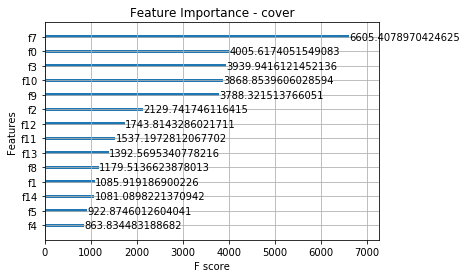

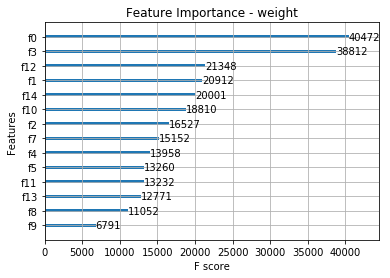

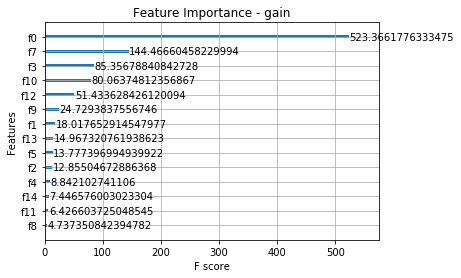

In [135]:
plot_importance(model, importance_type='cover', title='Feature Importance - cover')
pyplot.show()
plot_importance(model, importance_type='weight', title='Feature Importance - weight')
pyplot.show()
plot_importance(model, importance_type='gain', title='Feature Importance - gain')
pyplot.show()

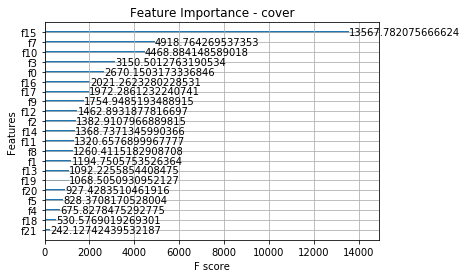

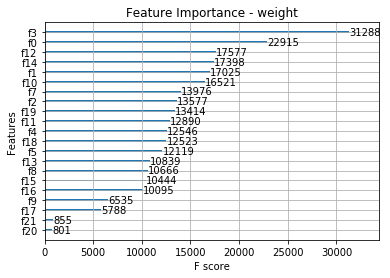

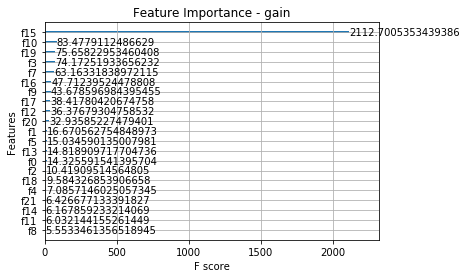

In [32]:
plot_importance(model, importance_type='cover', title='Feature Importance - cover')
pyplot.show()
plot_importance(model, importance_type='weight', title='Feature Importance - weight')
pyplot.show()
plot_importance(model, importance_type='gain', title='Feature Importance - gain')
pyplot.show()

In [2]:
import pickle
from xgboost import plot_tree
model_name = './no_poly_4900_6.mdl'
# with open(model_name, 'wb') as f:
#     pickle.dump(model, f)
model = pickle.load(open(model_name, 'rb'))
# plot_tree(model, num_trees=0)

In [3]:
from xgboost import plot_importance
from matplotlib import pyplot
from graphviz import Digraph

In [5]:
# from xgboost import plot_tree
# import matplotlib.pyplot as plt
from matplotlib import pyplot
# import pydot
# plt.figure(figsize=(20,15))
# xgb.plot_tree(model)
# plt.show()
# from matplotlib.pylab import rcParams
# xgb.plot_tree(model, num_trees=2)
##set up the parameters
# rcParams['figure.figsize'] = 10,5
# xgb.to_graphviz(model, num_trees=0)
plot_tree(model)
pyplot.show()
# xgb.to_graphviz(model, num_trees=0, rankdir='LR')

Format: "png" not recognized. Use one of: canon cmap cmapx cmapx_np dot dot_json eps fig gv imap imap_np ismap json json0 mp pic plain plain-ext pov ps ps2 svg svgz tk vml vmlz xdot xdot1.2 xdot1.4 xdot_json


CalledProcessError: Command '['dot', '-Tpng']' returned non-zero exit status 1.

In [121]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_err_ids_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)
doc_teams_all_dict = defaultdict(list)
doc_teams_errors_dict = defaultdict(list)
doc_men_ent_dict = defaultdict(dict)

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    
    q_id = literal_eval(res[key][0])[0]
    predicted_g_val = val[0]
    r_sorted_arr = np.sort(val)[::-1]
    g_ent_rank = np.where(r_sorted_arr==predicted_g_val)[0][0] + 1
#     men, doc_id = fetch_mention_by_q_id(q_id)
    men, g_ent, doc_id = fetch_mention_ent_by_q_id(q_id)
    
    if doc_id not in doc_men_ent_dict:
        for x in doc_ids:
            doc_men_ent_dict[x] = dict(fetch_men_ents_by_doc_id(x))
            for men_id, ent in doc_men_ent_dict[x].items():
                ent_labels = fetch_ent_cates_by_ent_id(escape_entity(ent))
                if ent_labels and "sports team" in ent_labels[0]:
                    doc_teams_all_dict[x].append(men_id)
    
    if doc_id not in doc_men_cnt_dict:
        doc_men_cnt_dict[doc_id] = fetch_mention_count_by_doc_id(doc_id)[0]
    
    
    pred_ent = literal_eval(res[key+np.argmax(val)][0])[1]
    
    doc_err_ids_dict[doc_id].append(q_id)
    
    if q_id in doc_teams_all_dict[doc_id]:
        doc_teams_errors_dict[doc_id].append(q_id)
        
    doc_err_dict[doc_id].append(str(q_id)+ ': ' + men + '->' + escape_entity(g_ent) + '->' + str(g_ent_rank) + '->' + escape_entity(pred_ent))
    if men.isupper():
        print(men, doc_id)

JAPAN 1163 SOCCER
CHINA 1163 SOCCER
OAKLAND 1239 Russ
PHOENIX 1385 NHL
BOSTON 1385 NHL
CHICAGO 1385 NHL
LPGA 1347 GOLF
MONTREAL 1385 NHL
TORONTO 1385 NHL
VANCOUVER 1186 NHL
PITTSBURGH 1385 NHL
LOS ANGELES 1186 NHL
ASIAN CUP 1382 SOCCER
WEST INDIES 1180 CRICKET
MONTREAL 1186 NHL
EDS 1227 Electronic
MELBOURNE 1180 CRICKET
CHICAGO 1186 NHL
FSA 1274 BALANCE
PHILADELPHIA 1186 NHL
ITALY 1164 RUGBY
DALLAS 1186 NHL
RTRS 1331 RTRS
OTTAWA 1186 NHL
CHICAGO 1386 NHL
ATLANTIC 1383 NBA
NLD 1267 Burmese
NLD 1267 Burmese
NEW YORK 1383 NBA
WORLD GRAND PRIX 1359 BADMINTON
EUROLEAGUE 1209 BASKETBALL
DES MOINES 1277 Iowa-S
WASHINGTON 1383 NBA
BOSTON 1187 NHL
PHILADELPHIA 1383 NBA
NORTHERN IRELAND 1364 SOCCER
NEW JERSEY 1383 NBA
JAPAN 1165 SOCCER
LEEDS 1171 SOCCER
BOSTON 1383 NBA
CENTRAL DIVISION 1383 NBA
SYRIA 1165 SOCCER
CHICAGO 1383 NBA
AUSTRALIA 1375 RUGBY
DETROIT 1383 NBA
BARBARIANS 1375 RUGBY
CLEVELAND 1383 NBA
ATLANTA 1383 NBA
INDIANAPOLIS 1188 NFL
CHARLOTTE 1383 NBA
EUROLEAGUE 1172 BASKETBALL
WORLD

In [192]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    
    q_id = literal_eval(res[key][0])[0]
    predicted_g_val = val[0]
#     sec_min_val, max_val = np.partition(val.flatten(), -2)[-2:]
    r_sorted_arr = np.sort(val)[::-1]
    g_ent_rank = np.where(r_sorted_arr==predicted_g_val)[0][0] + 1
#     res[key+len(val)]
    men, doc_id = fetch_mention_by_q_id(q_id)
    if doc_id not in doc_men_cnt_dict:
        doc_men_cnt_dict[doc_id] = fetch_mention_count_by_doc_id(doc_id)[0]
    men, ent, doc_id = fetch_mention_ent_by_q_id(q_id)
    pred_ent = literal_eval(res[key+np.argmax(val)][0])[1]
    doc_err_dict[doc_id].append(str(q_id)+ ': ' + men + '->' + escape_entity(ent) + '->' + str(g_ent_rank) + '->' + escape_entity(pred_ent))
    if men.isupper():
        print(men, doc_id)

JAPAN 1163 SOCCER
CHINA 1163 SOCCER
OAKLAND 1239 Russ
BOSTON 1385 NHL
BUFFALO 1385 NHL
WASHINGTON 1385 NHL
CHICAGO 1385 NHL
LPGA 1347 GOLF
MONTREAL 1385 NHL
TORONTO 1385 NHL
VANCOUVER 1186 NHL
PITTSBURGH 1385 NHL
MELBOURNE 1179 CRICKET
BUFFALO 1186 NHL
MONTREAL 1186 NHL
AUSTRALIA 1180 CRICKET
EDS 1227 Electronic
CHICAGO 1186 NHL
CUTTITTA 1164 RUGBY
FSA 1274 BALANCE
PHILADELPHIA 1186 NHL
ITALY 1164 RUGBY
DALLAS 1186 NHL
HOBART 1181 CRICKET
RTRS 1331 RTRS
OTTAWA 1186 NHL
CHICAGO 1386 NHL
ATLANTIC 1383 NBA
NLD 1267 Burmese
NLD 1267 Burmese
NEW YORK 1383 NBA
BOSTON 1187 NHL
PHILADELPHIA 1383 NBA
NORTHERN IRELAND 1364 SOCCER
NEW JERSEY 1383 NBA
JAPAN 1165 SOCCER
LEEDS 1171 SOCCER
CENTRAL DIVISION 1383 NBA
SYRIA 1165 SOCCER
CHICAGO 1383 NBA
AUSTRALIA 1375 RUGBY
DETROIT 1383 NBA
BARBARIANS 1375 RUGBY
LOS ANGELES 1187 NHL
CLEVELAND 1383 NBA
ATLANTA 1383 NBA
INDIANA 1383 NBA
INDIANAPOLIS 1188 NFL
EUROLEAGUE 1172 BASKETBALL
WORLD CUP 1205 SOCCER
HOUSTON 1383 NBA
MINNESOTA 1383 NBA
NEW YORK 1232 

In [122]:
total_sports = 0
total_err_sports = 0
total_correct_sports = 0
for doc_id, mens in doc_err_dict.items():
    print('Doc ID: ' + doc_id)
    print('Total errors: ' + str(len(mens)) + '    total mentions: ' + str(doc_men_cnt_dict[doc_id]))
    total_sports += len(doc_teams_all_dict[doc_id])
    total_err_sports += len(doc_teams_errors_dict[doc_id])
    print('Total errors (sports teams): ' + str(len(doc_teams_errors_dict[doc_id])) + '    total mentions (sports teams):' + str(len(doc_teams_all_dict[doc_id])))
    print('All Errors mentions:\n{}'.format('\n'.join(mens)))
    print('Correct Mentions (sports teams):')
    correct_teams = [x for x in doc_teams_all_dict[doc_id] if x not in doc_teams_errors_dict[doc_id]]
    for q_id in correct_teams:
        total_correct_sports +=1
        men, ent, doc_id = fetch_mention_ent_by_q_id(q_id)
        print(str(q_id) + ": " + men + '->' + escape_entity(ent))
    print('\n')

Doc ID: 1163 SOCCER
Total errors: 22    total mentions: 38
Total errors (sports teams): 15    total mentions (sports teams):19
All Errors mentions:
400495: JAPAN->Japan_national_football_team->2->Japan
400496: CHINA->China_PR_national_football_team->5->People's_Republic_of_China
400500: Japan->Japan_national_football_team->2->Japan
400501: Asian Cup->1996_AFC_Asian_Cup->4->2007_AFC_Asian_Cup
400502: Syria->Syria_national_football_team->2->Syria
400503: China->China_PR_national_football_team->5->People's_Republic_of_China
400505: China->China_PR_national_football_team->5->People's_Republic_of_China
400506: Uzbek->Uzbekistan_national_football_team->2->Uzbekistan
400511: Asian Cup->AFC_Asian_Cup->2->2007_AFC_Asian_Cup
400512: Asian Games->1994_Asian_Games->8->Asian_Games
400514: Japan->Japan_national_football_team->2->Japan
400515: Syria->Syria_national_football_team->2->Syria
400518: Syrian->Syria_national_football_team->2->Syria
400520: Syria->Syria_national_football_team->2->Syria
4005

In [87]:
total_sports = 0
# total_err_sports = 0
# total_correct_sports = 0
for x, y in doc_teams_all_dict.items():
    total_sports += len(y)
    print(x)
#     doc_teams_all_dict[x].append(men_id)

1199 SOCCER
1208 SOCCER
1209 BASKETBALL
1373 SOCCER
1191 NFL
1196 SOCCER
1167 SOCCER
1164 RUGBY
1369 SOCCER
1198 SOCCER
1370 SOCCER
1205 SOCCER
1364 SOCCER
1371 SOCCER
1170 SOCCER
1176 SOCCER
1380 SOCCER
1390 SOCCER
1195 SOCCER
1194 SOCCER
1169 SOCCER
1201 SOCCER
1366 SOCCER
1165 SOCCER
1172 BASKETBALL
1163 SOCCER
1385 NHL
1368 SOCCER
1202 SOCCER
1171 SOCCER
1389 SOCCER
1173 RUGBY
1392 SOCCER
1204 SOCCER
1386 NHL
1362 SOCCER
1206 SOCCER
1374 RUGBY
1365 RUGBY
1367 RUGBY
1207 GUNMEN
1375 RUGBY
1188 NFL
1190 NFL
1383 NBA
1384 NBA
1382 SOCCER
1391 SOCCER
1175 SOCCER
1377 SOCCER
1381 SOCCER
1186 NHL
1189 NBA
1187 NHL
1197 SOCCER
1393 SOCCER
1387 NHL
1372 SOCCER
1193 SOCCER
1363 SOCCER
1251 Russia
1357 FREESTYLE
1326 British
1239 Russ
1263 Chile
1168 CRICKET
1347 GOLF
1327 Court
1192 NCAA
1348 ALPINE
1285 Half
1226 Major
1179 CRICKET
1349 ALPINE
1264 Indonesia
1216 POLAND
1351 NORDIC
1227 Electronic
1272 Texas
1180 CRICKET
1330 NZ
1300 OPEC
1274 BALANCE
1301 Relations
1228 RTRS
1331 RTRS
126

In [163]:
for key, val in wrong_results.items():
    q_id = literal_eval(res[key][0])[0]
    print(literal_eval(res[key+np.argmax(val)][0])[1])
    break

John_Lewis_(department_store)


In [29]:
from ast import literal_eval
import os
import re

doc_err_dict = defaultdict(list)
doc_men_cnt_dict = defaultdict(int)
doc_g_ent_rank_dict = defaultdict(int)

re_train_errs_list = []

def escape_entity(entity):
    return str.encode(entity).decode('unicode-escape')

for key, val in wrong_results.items():
    re_train_errs_list.append(d_test[key: key + len(val),])

In [31]:
re_train_errs_list = np.array([y for x in re_train_errs_list for y in x])

In [32]:
re_train_errs_list

array([[  3.95657000e+05,   5.38699841e-03,   2.27000000e+02,
          9.66352165e-01,   1.44129634e-05,   1.22903721e+01,
          2.41088505e+01,   0.00000000e+00,   2.21415951e+01,
          4.17763426e+01,   1.69897000e+00,   4.82183793e-02,
          1.17646963e-01,   1.26847481e-02,   1.59468097e-02,
          4.91472388e-02,   1.00000000e+00],
       [  3.95657000e+05,   9.66352165e-01,   2.27000000e+02,
          9.66352165e-01,   1.75960339e-03,   7.72787276e+00,
          1.60356614e+01,   0.00000000e+00,   9.14542201e+00,
          1.73143251e+01,   1.09691001e+00,   6.05353448e-03,
          1.04339988e-02,   1.68593449e-03,   2.97329727e-03,
          3.56879173e-02,   0.00000000e+00]])

In [33]:
dtest_re = trans_data(re_train_errs_list)

[[  5.38699841e-03   2.27000000e+02   9.66352165e-01 ...,   1.26847481e-02
    1.59468097e-02   4.91472388e-02]
 [  9.66352165e-01   2.27000000e+02   9.66352165e-01 ...,   1.68593449e-03
    2.97329727e-03   3.56879173e-02]
 [  6.05688430e-03   2.27000000e+02   9.66352165e-01 ...,   5.64931261e-03
    1.02734407e-02   6.30971696e-02]
 ..., 
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   9.47476211e-03
    5.50338912e-02   1.66723449e-01]
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   1.30768280e-02
    1.07783010e-02   8.24229005e-02]
 [  3.85208026e-04   1.03000000e+02   7.35362113e-01 ...,   2.41756367e-02
    8.38351525e-02   2.13256234e-01]]
[ 1.  0.  0. ...,  0.  0.  0.]
[50 50  3 50 50 50 42  2  2 14  2 50  2 50 50  6  6 23 50 42  2 50 50 50 50
 50  2  3  2 12 50 50 50 50 50 50 44  8 50 17 50 50 14  8 50  2 50  7 50 50
 25  5 25  7  2 50  4 28 50 24 50  2  2 50  7 48 28 50 50 50 50 42 50  4  8
 50 50 50 50  4 10 50 17 24 19 50  4 50  5 20  5  4 50 50 50 

In [61]:
num_round=150
param = {'max_depth':6, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
model_new = xgb.train(param, dtest_re, num_round, xgb_model=model)

In [62]:
preds = model.predict(dtest)
a = evalerror_detail_log(preds, dtest, 4791)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767


In [63]:
preds = model_new.predict(dtest)
a = evalerror_detail_log(preds, dtest, 4791)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 4372, precision: 0.9247038917089678, recall: 0.9125443539970779, f1: 0.9185838848618552


In [64]:
preds = model.predict(dtest_b)
a = evalerror_detail_log(preds, dtest_b, 4485)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711


In [65]:
preds = model_new.predict(dtest_b)
a = evalerror_detail_log(preds, dtest_b, 4485)
print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))

correct_num: 3884, precision: 0.8735942420152947, recall: 0.8659977703455964, f1: 0.8697794199977606


In [67]:
n_estimators = range(10, 200, 20)
max_depth = [2, 4, 6]
for x in n_estimators:
    num_round = x
    for dep in max_depth:
        param = {'max_depth':dep, 'eta':0.01, 'silent':0, 'objective':'rank:pairwise', 'min_child_weight':0.01}
        model_new = xgb.train(param, dtest_re, num_round, xgb_model=model)
        preds = model_new.predict(dtest)
        a = evalerror_detail_log(preds, dtest, 4791)
        print("correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767")
        print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))
        print('\n')
        print("correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711")
        preds = model_new.predict(dtest_b)
        a = evalerror_detail_log(preds, dtest_b, 4485)
        print("correct_num: {}, precision: {}, recall: {}, f1: {}".format(a[0], a[1], a[2], a[3]))
        print('________________________________________________________')

correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767
correct_num: 4294, precision: 0.9082064297800339, recall: 0.8962638280108537, f1: 0.9021956087824351


correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711
correct_num: 3950, precision: 0.8884390463337831, recall: 0.8807134894091416, f1: 0.8845593998432427
________________________________________________________
correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805, f1: 0.9005147599537767
correct_num: 4290, precision: 0.9073604060913706, recall: 0.8954289292423294, f1: 0.9013551843681058


correct_num: 3946, precision: 0.8875393612235718, recall: 0.8798216276477147, f1: 0.8836636434889711
correct_num: 3954, precision: 0.8893387314439946, recall: 0.8816053511705686, f1: 0.8854551561975141
________________________________________________________
correct_num: 4286, precision: 0.9065143824027073, recall: 0.894594030473805,

In [88]:
total_sports, total_err_sports, total_correct_sports

(966, 192, 624)

In [276]:
get_men_tokens_redis('aida_conll','1239 Russ')

{'': [4],
 '1996 - 12 - 06': [7],
 'a. curts cooke': [12],
 'chief': [15],
 'co inc': [9],
 'company': [23],
 'consulting': [21],
 'continue': [25],
 'cooke': [19],
 'director': [27],
 'effective july 1 , 1997': [18],
 'friday': [11],
 'gift': [29],
 'july': [3],
 'july 1 , 1998': [24],
 'maker': [30],
 'n.j.': [6],
 'oakland': [5],
 'officer': [17],
 'operating': [16],
 'president': [1, 14],
 'provide': [20],
 'retire': [2, 13],
 'russ berrie': [0, 8],
 'say': [10, 31],
 'serve': [26],
 'service': [22],
 'toy': [28]}

In [266]:
'john lewis partnership'.upper()

'JOHN LEWIS PARTNERSHIP'

In [1]:
import spacy

print(spacy.__version__)

2.0.2


In [2]:
nlp = spacy.load('en_core_web_md')

In [77]:
doc_text = '''Russ Berrie president to retire in July.
 OAKLAND, N.J. 1996-12-06
 Russ Berrie and Co Inc said on Friday that A. Curts Cooke will retire as president and chief operating officer effective July 1, 1997.
 Cooke will provide consulting services to the company through July 1, 1998, and will continue to serve as a director, the toy and gift maker said.
 '''

In [78]:
doc = nlp(doc_text)

In [80]:
from collections import defaultdict
filter_ent_types = ('DATE', 'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL')
x = defaultdict(list)
for ent in doc.ents:
    if ent.label_ not in filter_ent_types:
        x[ent.text].append(ent.start_char)
    print(ent, ent.label_)

Russ Berrie PERSON
July DATE
OAKLAND ORG
N.J. GPE
1996 DATE
Russ Berrie PERSON
Co Inc ORG
Friday DATE
A. Curts Cooke PERSON
July 1, 1997 DATE
Cooke PERSON
July 1, 1998 DATE


In [81]:
x

defaultdict(list,
            {'A. Curts Cooke': [111],
             'Co Inc': [84],
             'Cooke': [204],
             'N.J.': [51],
             'OAKLAND': [42],
             'Russ Berrie': [0, 68]})

In [104]:
a = np.array([0.3,  0.3,  0. ,  0.3,  0.3,  0. ])

In [105]:
b = np.array([True, True, False, True, True, False], dtype=np.bool)

In [16]:
a = np.array([[2,  0.1, 1], [1,  0.3, 1],  [1 ,  0.4, 0], [3, 1,1], [3, 2, 0]])
b = np.array([[1,  0, 1],  [1 ,  4, 0],  [2,  1, 1], [3, 0.1,1], [3, 0.2, 0]])

In [60]:
def combine_features(original_feas, new_features):
    men_id_feas_dict = defaultdict(list)
    for fea in new_features:
        men_id_feas_dict[fea[0]].append(fea)
    comb_feas = None
    pre_men_id = 0
#     print(men_id_feas_dict)
    for fea_idx, fea in enumerate(original_feas):
#         print(fea_idx)
        if pre_men_id == fea[0]:
            continue
        else:
            pre_men_id = fea[0]
            fea_size = len(men_id_feas_dict[fea[0]])
#             print(pre_men_id)
#             print(fea_size)
#             print(original_feas[fea_idx: fea_idx + fea_size, :-1])
#             s = men_id_feas_dict[fea[0]]
#             print(np.array(s)[:, 1:])
            res = np.append(original_feas[fea_idx: fea_idx + fea_size, :-1], np.array(men_id_feas_dict[fea[0]])[:, 1:], axis=1)
            comb_feas = np.concatenate((comb_feas, res), axis=0) if comb_feas is not None else res
    return comb_feas

In [61]:
combine_features(a, b)

array([[ 2. ,  0.1,  1. ,  1. ],
       [ 1. ,  0.3,  0. ,  1. ],
       [ 1. ,  0.4,  4. ,  0. ],
       [ 3. ,  1. ,  0.1,  1. ],
       [ 3. ,  2. ,  0.2,  0. ]])

In [2]:
import numpy as np
a = np.array([[2,  0.1, 1], [1,  0.3, 1],  [1 ,  0.4, 0], [3, 1,1], [3, 2, 0]])
b = np.array([[1,  0, 1],  [1 ,  4, 0],  [2,  1, 1], [3, 0.1,1], [3, 0.2, 0]])

In [4]:
np.concatenate((a, b), axis=1)

array([[ 2. ,  0.1,  1. ,  1. ,  0. ,  1. ],
       [ 1. ,  0.3,  1. ,  1. ,  4. ,  0. ],
       [ 1. ,  0.4,  0. ,  2. ,  1. ,  1. ],
       [ 3. ,  1. ,  1. ,  3. ,  0.1,  1. ],
       [ 3. ,  2. ,  0. ,  3. ,  0.2,  0. ]])

In [84]:
import spacy
from spacy import displacy

ex = {'text': 'But Google is starting from behind.',
       'ents': [{'start': 4, 'end': 10, 'label': 'ORG'}],
       'title': None}
html = displacy.render(ex, style='ent', manual=True)

In [85]:
print(html)

<div class="entities" style="line-height: 2.5">But 
<mark class="entity" style="background: #7aecec; padding: 0.45em 0.6em; margin: 0 0.25em; line-height: 1; border-radius: 0.35em; box-decoration-break: clone; -webkit-box-decoration-break: clone">
    Google
    <span style="font-size: 0.8em; font-weight: bold; line-height: 1; border-radius: 0.35em; text-transform: uppercase; vertical-align: middle; margin-left: 0.5rem">ORG</span>
</mark>
 is starting from behind.</div>


In [120]:
import re
doc = '[[Beij,. "(ing]] is a [[city]].'

In [127]:
for m in re.finditer(r'\[\[([^\]])*\]\]', doc):
    print(m.start(), m.end())

0 16
22 30


In [129]:
len(doc.split())

5

In [125]:
ss = conn.hmget('men-ner-stanford-aida_conll', '1163 SOCCER')[0]

In [128]:
ss = json.loads(ss)

In [129]:
ss.keys()

dict_keys(['nader jokhadar', 'bitar', 'kuwait', 'nadim ladki', 'world cup', 'shu kamo', 'oleg shatskiku', 'hiroshige yanagimoto', 'asian games', 'fifa', 'syrian', 'uzbek', 'hassan abbas', 'united arab emirates', 'uzbekistan', 'chinese', 'indonesia', 'china', 'soviet', 'salem bitar', 'al-ain', 'takuya takagi', 'japan', 'south korea', 'syrians', 'igor shkvyrin', 'syria', 'asian cup'])

In [142]:
import spacy

nlp = spacy.load('en_core_web_md')

In [167]:
s = nlp('Emirates')

In [168]:
for t in s:
    print(t.lemma_)

emirate


In [158]:
import inflect
p = inflect.engine()

In [148]:
p.singular_noun('United Arab Emirates')

'syrian'